# Create a time series using a dask CLuster
* connect data to a horizontal slice from SMT simulation data
* examples for ssh, temperature and salinity


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
# import seawater as sw
import datetime

import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots
CPU times: user 1.72 s, sys: 1.36 s, total: 3.07 s
Wall time: 5.27 s


## Simulation details

In [2]:
run = 'ngSMT_tke'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

In [3]:
## choose month
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/{run}'

In [59]:
#### prep. dask cluster
search_str = f'_h_sp_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [96]:
### Temperature
#### prep. dask cluster
search_str = f'_T_S_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

optional cluster arguments:

'mfdset_kwargs = dict(combine='nested', concat_dim='flist', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )'

## create a dask Cluster

In [8]:
## Start cluster

!echo $HOSTNAME

mlogin104


In [9]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "320GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [10]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [11]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=320G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/u/u241317/PostProcwn_t88c1
#SBATCH --begin=now
#SBATCH --output=/scratch/u/u241317/PostProcwn_t88c1/LOG_cluster.%j.o
#SBATCH --output=/scratch/u/u241317/PostProcwn_t88c1/LOG_cluster.%j.o

/work/mh0033/u241317/miniconda3/envs/pyicon_py38/bin/python -m distributed.cli.dask_worker tcp://10.50.32.33:44688 --nthreads 4 --nprocs 6 --memory-limit 53.33GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/u/u241317/PostProcwn_t88c1 --interface ib0 --protocol tcp://



In [12]:
cluster.scale(jobs=2)
cluster

In [14]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34249649       gpu PostProc  u241317  R       0:13      1 mg205
          34249650       gpu PostProc  u241317  R       0:13      1 mg207


In [15]:
client = Client(cluster)
client

<Client: 'tcp://10.50.32.33:44688' processes=0 threads=0, memory=0 B>

## Load data

In [17]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [97]:
%%time
dh = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs
dh = dh.assign_coords({"clon": ("ncells", clon)})
dh = dh.assign_coords({"clat": ("ncells", clat)})

h = dh.S001_sp
#h = dh.h_sp
#h = dh.T001_sp.T

CPU times: user 1.01 s, sys: 30 ms, total: 1.04 s
Wall time: 1.2 s


### select region

In [101]:
#lon = [-64.8, -64.6]
#lat = [39.6, 39.8]
h = h.where((h.clat > 39.6) & (h.clat < 39.8) & (h.clon > -64.8) & (h.clon < -64.6), drop=True)

### compute and save data

In [102]:
#fpath = f'{path_scratch}/time_series_analysis_ssh_2d_1.nc'
fpath = f'{path_scratch}/time_series_analysis_S_2d_3.nc'
print(f'Saving file {fpath}')
h.to_netcdf(fpath)

Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//time_series_analysis_S_2d_3.nc


repeat this process for the three simulated month of the SMT datasets - dont forget to change filenames ;)

### combine data of 3 month using time

In [104]:
#### prep. dask cluster
path_data = path_scratch
#search_str = f'time_series_analysis_ssh_2d_*.nc' 
search_str = f'time_series_analysis_S_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [106]:
dH = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs

### save final dataset

In [107]:
#fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_ssh_2d.nc'
fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_S_2d.nc'
print(f'Saving file {fpath}')
dH.to_netcdf(fpath)

Saving file /work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_S_2d.nc


#### a first glance on the new dataset

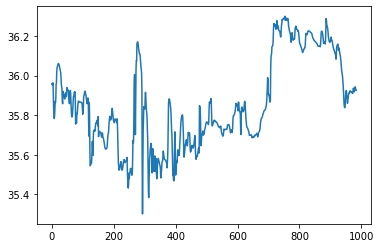

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

tt = dH.isel(ncells=500)
#fig, ax = plt
plt.plot(tt.S001_sp)
#plt.show()

#### close cluster properly

In [ ]:
client.close()
cluster.close()